Introductory example to using GPry
----------------------------------

This notebook will guide you through the basic steps for sampling a likelihood with GPry

### Step 1: Setting up a likelihood function

Let's set up a simple 2d Gaussian likelihood as an example:

$$y(x) \sim \mathcal{N}(x|\mu,\Sigma)$$

with 
$$\mu=\begin{pmatrix}3 \\ 2\end{pmatrix},\ \Sigma=\begin{pmatrix}0.5 & 0.4 \\ 0.4 & 1.5\end{pmatrix}$$

**Note that we need to pass GPry the log-Likelihood!**

In [1]:
import numpy as np
from scipy.stats import multivariate_normal

mean = [3, 2]
cov = [[0.5, 0.4], [0.4, 1.5]]
rv = multivariate_normal(mean, cov)

def logLkl(x_1, x_2):
    return rv.logpdf(np.array([x_1, x_2]).T)

and some bounds which we set to $[-10, 10]$ for both paramters

In [2]:
bounds = [[-10, 10], [-10, 10]]

### Step 2: Creating the Runner object

The `run.Runner` manages model specification and the active sampling loop of GPry up to convergence, as well as allows for some post-processing and tests.

To initialise it, we pass it the log-likelihood function as first argument, and the prior bounds via the ``bounds`` keyword (more complicated prior specifications can be used by defining and passing as first argument a `Cobaya` model).

Optionally, we can also also pass a path to save checkpoints via the ``checkpoint`` argument. 

If passed, in order to prevent loss of data, you **must** decide a checkpoint policy (either ``"resume"`` or ``"overwrite"``). 

- If set to ``"resume"`` the runner object will try to load the checkpoint and resume the active sampling loop from there
- If set to ``"overwrite"`` it will start from scratch and overwrite checkpoint files which already exist.


In [ ]:
from gpry.run import Runner
checkpoint = "output/simple"
runner = Runner(logLkl, bounds, checkpoint=checkpoint, load_checkpoint="overwrite")

### Step 3: Running the active learning loop

Since all training parameters are chosen automatically, all we have to do is to call the
`run` function of the runner object:


In [ ]:
runner.run()

This will run the active sampling loop until convergence is reached. 

It also saves the checkpoint files after every iteration of the bayesian optimization loop and creates progress plots which are saved in `[checkpoint]/images/` (`./images/` if checkpoint is None).

Once converged, you can access the surrogate model and use it as a function for any purpose. 

Note that internally GPry models the **log-posterior**, not the log-likelihood and that you need to hand GPry a single (nsamples, ndim) with the locations where you want to evaluate the surrogate.

Nevertheless we can call either `runner.logp` or `runner.logL`

Let us compare GPry and the likelihood in the location (1, 2): 

In [5]:
point = (1, 2)
print(f"Log-lkl at (1,2): {logLkl(*point)}")
print(f"surrogate at (1,2): {runner.logL(point)[0]}")

Log-lkl at (1,2): -6.658806458080024
surrogate at (1,2): -6.659817746858454


Both evaluations should produce similar numbers.

Congratulations, now you have a surrogate of your posterior distribution!!!

----

Now let's see how you make corner plots and get marginalised quantities.

### Step 4: Running a Monte Carlo sampler on the surrogate model

The ``Runner`` object can also run an MC sampler on the GP in order to extract marginalised quantities. To do that, we use the `generate_mc_sample` method of the ``Runner``. Leaving all option to their default, it will use the same sampler as for the active learning:

In [ ]:
runner.generate_mc_sample()

Samples are by default stored in the same folder as the `checkpoint`, inside a `chains` sub folder. They are stored as an attribute of the Runner and can be retrieved with the `last_mc_samples()` method.

### Bonus: Plotting the results with GetDist

Now that we have MC samples you can process and plot them the same way that you would do with any other MC samples.

The easiest way to get a corner plot though is to call the `plot_mc` method of the ``Runner`` object which will generate a `GetDist` corner plot.

It includes the training set unless passed ``add_training=False``.

Removed no burn in


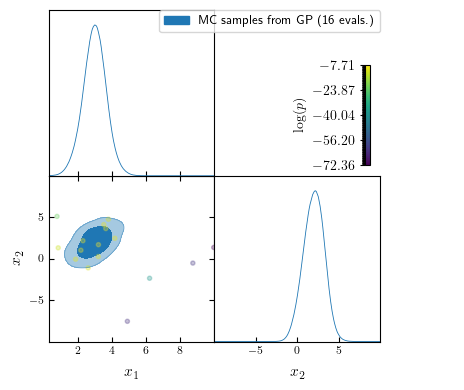

In [10]:
runner.plot_mc()

### Bonus: Getting some extra insights

You can do further plots about the progress of the active-learning loop using:

In [8]:
runner.plot_progress()

Removed no burn in


This results in the following: 
- a histogram of the distribution time spent at different parts of the code (`timing.png`)
- the distribution of the training samples (`trace.png`)
- A plot showing the value(s) of all convergence criteria as function of the number of posterior evaluations (`convergence.png`)

The plots are saved in `[checkpoint]/images/` (`./images/` if checkpoint is None).

### Bonus Bonus: Validation

**This part is optional and only relevant for validating the contours that GPry produces. In a realistic scenario you would obviously not run a full MCMC on the likelihood**

To compare our contours to the true Gaussian we draw 10000 samples from it and plot the contours on top:

Removed no burn in
Removed no burn in


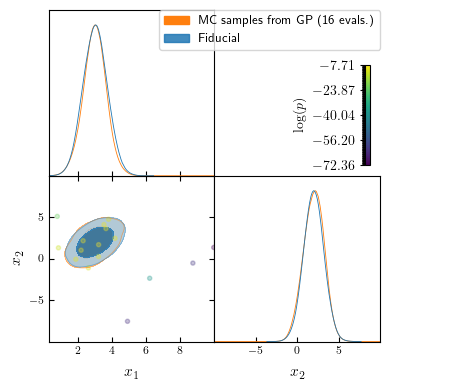

In [9]:
from getdist import MCSamples
samples_truth = MCSamples(samples=rv.rvs(size=10000), names=["x_1", "x_2"])

runner.plot_mc(add_samples={"Fiducial": samples_truth})